### pulp+cbcを用いて、ノードを離散化して不在確率込みのTSPを解く

In [1]:
import random, math
import pulp
import itertools
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

%matplotlib inline

### データの作成

In [2]:
START_NODE = 0
NUM_NODE = 10
NUM_PERIOD = NUM_NODE + 2
END_NODE = NUM_NODE + 1
AREA_SIZE = 20

In [3]:
list_node_with_start_end = list(range(START_NODE, NUM_NODE + 2))
list_node_with_start = list(range(START_NODE, NUM_NODE + 1))
list_node_with_end = list(range(1, NUM_NODE + 2))
list_node = list(range(1, NUM_NODE + 1))
list_period = list(range(1, NUM_PERIOD + 1))

In [4]:
node_coordinate_map = {}
for n in list_node:
    node_coordinate_map[n] = (random.randint(0, AREA_SIZE), random.randint(0, AREA_SIZE))

In [5]:
node_period_proba_map = {}
for n in list_node:
    for t in list_period:
        node_period_proba_map[n, t] = random.random()

In [6]:
node_node_dist_map = {}
for n1 in list_node:
    for n2 in list_node:
        x = node_coordinate_map[n1]
        y = node_coordinate_map[n2]
        node_node_dist_map[n1, n2] = euclidean(x, y)

### モデルの作成

In [7]:
model = pulp.LpProblem(name='time-dependence-tsp', sense=pulp.LpMinimize)
sense_map = {v: k for k, v in pulp.LpConstraintSenses.items()}

#### 変数の作成

In [8]:
x_ij = {}
for i in list_node_with_start:
    for j in list_node_with_end:
        if i==j:
            continue
        v = pulp.LpVariable(cat=pulp.LpBinary, name='x_%s_%s'%(i, j))
        x_ij[i, j] = v
        model.addVariable(v)

y_it = {}
for i in list_node_with_start_end:
    for t in list_period:
        v = pulp.LpVariable(cat=pulp.LpBinary, name='y_%s_%s'%(i, t))
        y_it[i, t] = v
        model.addVariable(v)

#### 制約式の作成

In [9]:
constr = pulp.LpConstraint(e=y_it[START_NODE, list_period[0]], sense=sense_map['='], rhs=1, name='first_node_constr')
model.addConstraint(constr)

constr = pulp.LpConstraint(e=y_it[END_NODE, list_period[-1]], sense=sense_map['='], rhs=1, name='end_node_constr')
model.addConstraint(constr)

In [10]:
x_expr = pulp.lpSum(x_ij[START_NODE, i] for i in list_node)
constr = pulp.LpConstraint(e=x_expr, sense=sense_map['='], rhs=1, name='first_edge_constr')
model.addConstraint(constr)

In [11]:
x_expr = pulp.lpSum(x_ij[i, END_NODE] for i in list_node)
constr = pulp.LpConstraint(e=x_expr, sense=sense_map['='], rhs=1, name='end_edge_constr')
model.addConstraint(constr)

In [12]:
for i in list_node_with_start_end:
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    constr = pulp.LpConstraint(e=y_expr, sense=sense_map['='],  rhs=1, name='node_visit_%s'%i)
    model.addConstraint(constr)

In [13]:
BigM = len(list_period)
for i in list_node_with_start:
    for j in list_node_with_end:
        if i == j:
            continue
        expr = pulp.lpSum((t + 1)* y_it[i, t] for t in list_period) - pulp.lpSum(t * y_it[j, t] for t in list_period) + \
                   BigM * x_ij[i, j]
        constr = pulp.LpConstraint(e=expr, sense=sense_map['<='], rhs=BigM, name='mtz_%s_%s'%(i, j))
        model.addConstraint(constr)

In [14]:
for i in list_node:
    x_expr = pulp.lpSum(x_ij[j, i] for j in list_node_with_start if (j, i) in x_ij)
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    constr = pulp.LpConstraint(e=x_expr - y_expr, sense=sense_map['='], rhs=0, name='node_in_%s'%i)
    model.addConstraint(constr)

In [15]:
for i in list_node:
    x_expr = pulp.lpSum(x_ij[i, j] for j in list_node_with_end if (i, j) in x_ij)
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    constr = pulp.LpConstraint(e=y_expr - x_expr, sense=sense_map['='], rhs=0, name='node_out_%s'%i)
    model.addConstraint(constr)

In [16]:
for i ,j in itertools.combinations(list_node, 2):
    x_expr = x_ij[i, j] + x_ij[j, i]
    constr = pulp.LpConstraint(e=x_expr, sense=sense_map['<='], rhs=1, name='path_cut_%s_%s'%(i, j))
    model.addConstraint(constr)

#### 目的関数の作成

In [17]:
objective_physical_dist = pulp.lpSum(node_node_dist_map[i, j] * x_ij[i, j] for i in list_node for j in list_node if (i, j) in x_ij)
objective_penalty_dist = pulp.lpSum(
                                            sum(node_node_dist_map[j, i] / (len(list_node) - 1) for j in list_node) * 
                                            node_period_proba_map[i, t] * 
                                            y_it[i, t] for i in list_node for t in list_period
                                     )

model.setObjective(objective_physical_dist + objective_penalty_dist)

#### 最適化の実行

In [18]:
solver = pulp.PULP_CBC_CMD(msg=1, maxSeconds=60, fracGap=0.1, threads=None)

In [19]:
model.writeLP('./model.lp')

In [20]:
status = pulp.LpStatus[model.solve(solver=solver)]

In [21]:
print(status)

Not Solved


### 結果の可視化

In [22]:
node_visitperiod_map = {}
for i in list_node_with_start_end:
    for t in list_period:
        if round(pulp.value(y_it[i, t]))==1:
            node_visitperiod_map[i] = t

In [23]:
list_visit_node = [i[0] for i in sorted(node_visitperiod_map.items(), key=lambda x: x[1])]

list_visit_path = []
for i, j in zip(list_visit_node, list_visit_node[1:]):
    if i==START_NODE or j==END_NODE:
        continue
    if (i, j) in x_ij and round(pulp.value(x_ij[i, j])) == 1:
        list_visit_path.append((i, j))

In [24]:
node_visitproba_map = {}

for k, v in node_visitperiod_map.items():
    if k==START_NODE or k==END_NODE:
        continue
    node_visitproba_map[k] = node_period_proba_map[k, v]

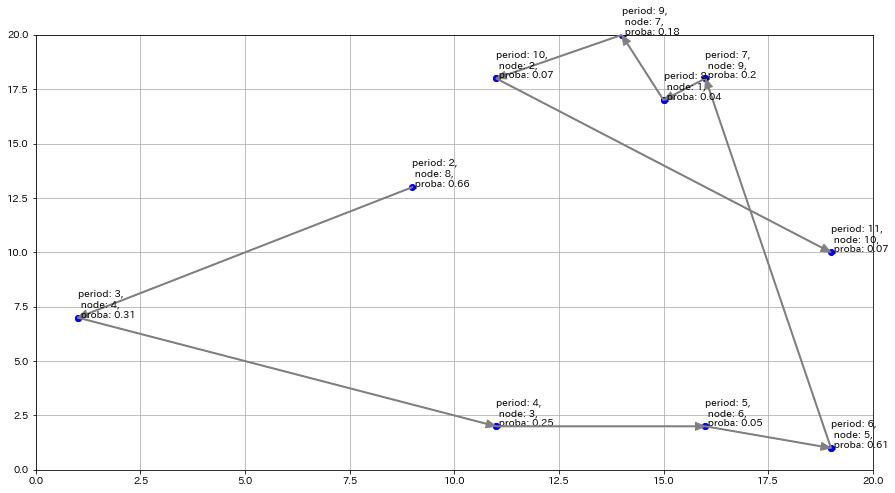

In [25]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.grid()
ax.set_xlim(0, AREA_SIZE)
ax.set_ylim(0, AREA_SIZE)
for i, path in enumerate(list_visit_path, start=1):
    start, end = path[0], path[1]
    # plot start node
    ax.plot(*node_coordinate_map[start], 'o', color='blue')
    visit_period = node_visitperiod_map[start]
    visit_proba = node_visitproba_map[start]
    label = 'period: %s, \n node: %s, \n proba: %s'%(visit_period, start, round(visit_proba, 2))
    ax.annotate(label, xy=node_coordinate_map[start], size=10)

    # plot end node
    ax.plot(*node_coordinate_map[end], 'o', color='blue')
    if i==len(list_visit_path):
        visit_period = node_visitperiod_map[end]
        visit_proba = node_visitproba_map[end]
        label = 'period: %s, \n node: %s, \n proba: %s'%(visit_period, end, round(visit_proba, 2))
        ax.annotate(label, xy=node_coordinate_map[end], size=10)

    # plot arrow
    ax.annotate('', 
                xy=node_coordinate_map[end], xytext=node_coordinate_map[start],
                arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                headlength=10, connectionstyle='arc3',
                                facecolor='gray', edgecolor='gray'))